<a href="https://colab.research.google.com/github/ThomasFJones/Reducing-Crime-In-Denver/blob/main/Denver_Assault_Report_Delay.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Prerequisites

This section is just importing the required models and data for this analysis

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# Introduction

For this project I will be utilizing the Denver Crime Data set accessible from Kaggle. The data set is of a good size, detailing over 500k incidents since 2017 and, unlike other crime data sets available on Kaggle, is regularly updated.

I’m going to focus in this project on the crime of Assault. Assault is the most common violent crime and often a pre-cursor to even more serious crimes such as rape and homicide. It is therefore important to make sure these offenses are responded to promptly both to prevent their immediate escalation where possible and to make apprehension of the perpetrator more likely in those cases where the police arrive after the fact.

In [ ]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
from datetime import datetime

df = pd.read_csv('/content/gdrive/My Drive/Data/crime.csv')

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Data Cleaning
In this section I narrow the data set to just those Offense Codes related to assault and remove some columns related to very specific geographic data (lat/long) that is not relevant to this analysis.

In [ ]:
df_ = df.loc[df['OFFENSE_CODE'] <= 1315]
assault = df_.loc[df['OFFENSE_CODE'] >= 1301]

In [ ]:
assault['OFFENSE_CODE'].sort_values().unique()

array([1310, 1311, 1313, 1314, 1315])

In [ ]:
assault['OFFENSE_TYPE_ID'].sort_values().unique()

array(['agg-aslt-police-weapon', 'aggravated-assault',
       'aggravated-assault-dv', 'aslt-agg-police-gun', 'assault-dv',
       'assault-police-simple', 'assault-simple',
       'menacing-felony-w-weap', 'weapon-fire-into-occ-bldg',
       'weapon-fire-into-occ-veh'], dtype=object)

In [ ]:
assault['OFFENSE_CATEGORY_ID'].sort_values().unique()

array(['aggravated-assault', 'all-other-crimes',
       'other-crimes-against-persons'], dtype=object)

In [ ]:
assault['IS_TRAFFIC'].sort_values().unique()

array([0])

In [ ]:
assault.shape

(38212, 19)

In [ ]:
assault.dtypes

INCIDENT_ID                 int64
OFFENSE_ID                  int64
OFFENSE_CODE                int64
OFFENSE_CODE_EXTENSION      int64
OFFENSE_TYPE_ID            object
OFFENSE_CATEGORY_ID        object
FIRST_OCCURRENCE_DATE      object
LAST_OCCURRENCE_DATE       object
REPORTED_DATE              object
INCIDENT_ADDRESS           object
GEO_X                     float64
GEO_Y                     float64
GEO_LON                   float64
GEO_LAT                   float64
DISTRICT_ID               float64
PRECINCT_ID               float64
NEIGHBORHOOD_ID            object
IS_CRIME                    int64
IS_TRAFFIC                  int64
dtype: object

In [ ]:
df_assault = assault.drop(columns= ['GEO_X', 'GEO_Y', 'GEO_LON', 'GEO_LAT', 'INCIDENT_ADDRESS', 'IS_CRIME', 'IS_TRAFFIC'])

In [ ]:
df_assault.dtypes

INCIDENT_ID                 int64
OFFENSE_ID                  int64
OFFENSE_CODE                int64
OFFENSE_CODE_EXTENSION      int64
OFFENSE_TYPE_ID            object
OFFENSE_CATEGORY_ID        object
FIRST_OCCURRENCE_DATE      object
LAST_OCCURRENCE_DATE       object
REPORTED_DATE              object
DISTRICT_ID               float64
PRECINCT_ID               float64
NEIGHBORHOOD_ID            object
dtype: object

# Feature Engineering



1.   Occurrence and reporting data converted to datetime
2.   Those datetimes use to create a timedelta of reporting delay
3. Timedelta converted to minutes as a float
4. Month, hour, and day of the week for each occurrence extracted into separate columns as int64.



In [ ]:
df_assault['FIRST_OCCURRENCE_DATE'] = pd.to_datetime(df_assault['FIRST_OCCURRENCE_DATE'])
df_assault['LAST_OCCURRENCE_DATE'] = pd.to_datetime(df_assault['LAST_OCCURRENCE_DATE'])
df_assault['REPORTED_DATE'] = pd.to_datetime(df_assault['REPORTED_DATE'])
df_assault['REPORTING_DELAY'] = (df_assault['REPORTED_DATE'] - df_assault['FIRST_OCCURRENCE_DATE'])
df_assault['REPORTING_DELAY'] = df_assault['REPORTING_DELAY'].dt.seconds/60
df_assault['OCCURENCE_MONTH'] = pd.DatetimeIndex(df_assault['FIRST_OCCURRENCE_DATE']).month
df_assault['OCCURENCE_HOUR'] = pd.DatetimeIndex(df_assault['FIRST_OCCURRENCE_DATE']).hour
df_assault['OCCURENCE_WEEKDAY'] = pd.DatetimeIndex(df_assault['FIRST_OCCURRENCE_DATE']).weekday


# Experiment #1 - Reporting Delay by Precinct

In this experiment I'm performing a one way Anova test to attempt to disprove than null hypothesis that there is no difference in the means of the reporting delay of assaults by precinct.

In [ ]:
## https://www.denvergov.org/content/dam/denvergov/Portals/720/documents/maps/Citywide_Map.pdf
df_assault['PRECINCT_ID'].sort_values().unique()

array([111., 112., 113., 121., 122., 123., 211., 212., 213., 221., 222.,
       223., 311., 312., 313., 314., 321., 322., 323., 324., 411., 412.,
       421., 422., 423., 511., 512., 521., 522., 523., 611., 612., 621.,
       622., 623., 759.])

In [ ]:
assault_111 = df_assault.loc[df_assault['PRECINCT_ID'] == 111]
assault_112 = df_assault.loc[df_assault['PRECINCT_ID'] == 112]
assault_113 = df_assault.loc[df_assault['PRECINCT_ID'] == 113]
assault_121 = df_assault.loc[df_assault['PRECINCT_ID'] == 121]
assault_122 = df_assault.loc[df_assault['PRECINCT_ID'] == 122]
assault_123 = df_assault.loc[df_assault['PRECINCT_ID'] == 123]
assault_211 = df_assault.loc[df_assault['PRECINCT_ID'] == 211]
assault_212 = df_assault.loc[df_assault['PRECINCT_ID'] == 212]
assault_213 = df_assault.loc[df_assault['PRECINCT_ID'] == 213]
assault_221 = df_assault.loc[df_assault['PRECINCT_ID'] == 221]
assault_222 = df_assault.loc[df_assault['PRECINCT_ID'] == 222]
assault_223 = df_assault.loc[df_assault['PRECINCT_ID'] == 223]
assault_311 = df_assault.loc[df_assault['PRECINCT_ID'] == 311]
assault_312 = df_assault.loc[df_assault['PRECINCT_ID'] == 312]
assault_313 = df_assault.loc[df_assault['PRECINCT_ID'] == 313]
assault_314 = df_assault.loc[df_assault['PRECINCT_ID'] == 314]
assault_321 = df_assault.loc[df_assault['PRECINCT_ID'] == 321]
assault_322 = df_assault.loc[df_assault['PRECINCT_ID'] == 322]
assault_323 = df_assault.loc[df_assault['PRECINCT_ID'] == 323]
assault_324 = df_assault.loc[df_assault['PRECINCT_ID'] == 324]
assault_411 = df_assault.loc[df_assault['PRECINCT_ID'] == 411]
assault_412 = df_assault.loc[df_assault['PRECINCT_ID'] == 412]
assault_413 = df_assault.loc[df_assault['PRECINCT_ID'] == 413]
assault_421 = df_assault.loc[df_assault['PRECINCT_ID'] == 421]
assault_422 = df_assault.loc[df_assault['PRECINCT_ID'] == 422]
assault_423 = df_assault.loc[df_assault['PRECINCT_ID'] == 423]
assault_511 = df_assault.loc[df_assault['PRECINCT_ID'] == 511]
assault_512 = df_assault.loc[df_assault['PRECINCT_ID'] == 512]
assault_513 = df_assault.loc[df_assault['PRECINCT_ID'] == 513]
assault_611 = df_assault.loc[df_assault['PRECINCT_ID'] == 611]
assault_612 = df_assault.loc[df_assault['PRECINCT_ID'] == 612]
assault_621 = df_assault.loc[df_assault['PRECINCT_ID'] == 621]
assault_622 = df_assault.loc[df_assault['PRECINCT_ID'] == 622]
assault_623 = df_assault.loc[df_assault['PRECINCT_ID'] == 623]
assault_759 = df_assault.loc[df_assault['PRECINCT_ID'] == 759]


# Test Result #1 - Reporting Delay by Precinct#

The incredibly low p-value disproves the null hypothesis and confirms the alternative hypothesis that there is a statistically significant difference in the delay between an assault accuring and the assault being reported between precincts. We'll be returning to this now established fact later in the analysis. 

In [ ]:
# removed 413, 513
stats.f_oneway(assault_111['REPORTING_DELAY'], assault_112['REPORTING_DELAY'], assault_113['REPORTING_DELAY'], 
               assault_121['REPORTING_DELAY'], assault_122['REPORTING_DELAY'], assault_123['REPORTING_DELAY'], 
               assault_211['REPORTING_DELAY'], assault_212['REPORTING_DELAY'], assault_213['REPORTING_DELAY'],
               assault_221['REPORTING_DELAY'], assault_222['REPORTING_DELAY'], assault_223['REPORTING_DELAY'],
               assault_311['REPORTING_DELAY'], assault_312['REPORTING_DELAY'], assault_313['REPORTING_DELAY'], assault_314['REPORTING_DELAY'],
               assault_321['REPORTING_DELAY'], assault_322['REPORTING_DELAY'], assault_323['REPORTING_DELAY'], assault_324['REPORTING_DELAY'],
               assault_411['REPORTING_DELAY'], assault_412['REPORTING_DELAY'], assault_421['REPORTING_DELAY'], assault_422['REPORTING_DELAY'], assault_423['REPORTING_DELAY'],
               assault_511['REPORTING_DELAY'], assault_512['REPORTING_DELAY'],
               assault_611['REPORTING_DELAY'], assault_612['REPORTING_DELAY'],
               assault_621['REPORTING_DELAY'], assault_622['REPORTING_DELAY'], assault_623['REPORTING_DELAY'],
               assault_759['REPORTING_DELAY'])

F_onewayResult(statistic=3.754519803391779, pvalue=4.182304157441347e-12)

# Experiment #2 - Reporting Delay by Month

In this experiment I'm performing a one way Anova test to attempt to disprove than null hypothesis that there is no difference in the means of the reporting delay of assaults by month of the year.




In [ ]:
month01 = df_assault.loc[df_assault['OCCURENCE_MONTH'] == 1]
month02 = df_assault.loc[df_assault['OCCURENCE_MONTH'] == 2]
month03 = df_assault.loc[df_assault['OCCURENCE_MONTH'] == 3]
month04 = df_assault.loc[df_assault['OCCURENCE_MONTH'] == 4]
month05 = df_assault.loc[df_assault['OCCURENCE_MONTH'] == 5]
month06 = df_assault.loc[df_assault['OCCURENCE_MONTH'] == 6]
month07 = df_assault.loc[df_assault['OCCURENCE_MONTH'] == 7]
month08 = df_assault.loc[df_assault['OCCURENCE_MONTH'] == 8]
month09 = df_assault.loc[df_assault['OCCURENCE_MONTH'] == 9]
month10 = df_assault.loc[df_assault['OCCURENCE_MONTH'] == 10]
month11 = df_assault.loc[df_assault['OCCURENCE_MONTH'] == 11]
month12 = df_assault.loc[df_assault['OCCURENCE_MONTH'] == 12]



# Test Result #2 - Reporting Delay by Month of Year#

With a pvalue of nearly .07, the null hypothsis is confirmed. Month of the Year does not appear to have a statistically significant effect on reporting delay of assaults.

In [ ]:
stats.f_oneway(month01['REPORTING_DELAY'],
               month02['REPORTING_DELAY'],
               month03['REPORTING_DELAY'],
               month04['REPORTING_DELAY'],
               month05['REPORTING_DELAY'],
               month06['REPORTING_DELAY'],
               month07['REPORTING_DELAY'],
               month08['REPORTING_DELAY'],
               month09['REPORTING_DELAY'],
               month10['REPORTING_DELAY'],
               month11['REPORTING_DELAY'],
               month12['REPORTING_DELAY'])

F_onewayResult(statistic=1.6946065077974062, pvalue=0.06790286348414207)

# Experiment #3 - Reporting Delay by Time of Day

In this experiment I'm performing a one way Anova test to attempt to disprove than null hypothesis that there is no difference in the means of the reporting delay of assaults by by time of day.

Deciding on specific groupings here presents something of a challenge. Measuring for each of the 24 hours of the day may result in groups so small or uneven that analysis becomes less reliable. Other methods of dividing the day such "morning", "afternoon", etc do not have precise, agreed upon definitions. 

I next considered group time by Police shifts, however because the Denver PD utilizes 10 hour shifts, these don't match up to the actual hours of the day and for obvious security and practical reasons the details of the shifts are not part of publicly available data.

In the end, I decided dividing the day into 3 hour octiles. Allowing the data sets to both contain enough individual points of data for analysis while still being narrow enough to be meaningful groupings.

In [ ]:
octile1 = df_assault.loc[(df_assault['OCCURENCE_HOUR'] >= 0) & (df_assault['OCCURENCE_HOUR'] <= 2)]
octile2 = df_assault.loc[(df_assault['OCCURENCE_HOUR'] >= 3) & (df_assault['OCCURENCE_HOUR'] <= 5)]
octile3 = df_assault.loc[(df_assault['OCCURENCE_HOUR'] >= 6) & (df_assault['OCCURENCE_HOUR'] <= 8)]
octile4 = df_assault.loc[(df_assault['OCCURENCE_HOUR'] >= 9) & (df_assault['OCCURENCE_HOUR'] <= 11)]
octile5 = df_assault.loc[(df_assault['OCCURENCE_HOUR'] >= 12) & (df_assault['OCCURENCE_HOUR'] <= 14)]
octile6 = df_assault.loc[(df_assault['OCCURENCE_HOUR'] >= 15) & (df_assault['OCCURENCE_HOUR'] <= 17)]
octile7 = df_assault.loc[(df_assault['OCCURENCE_HOUR'] >= 18) & (df_assault['OCCURENCE_HOUR'] <= 20)]
octile8 = df_assault.loc[(df_assault['OCCURENCE_HOUR'] >= 21) & (df_assault['OCCURENCE_HOUR'] <= 22)]

# Test Result #3- Reporting Delay by Time of Day#

The incredibly low p-value disproves the null hypothesis and confirms the alternative hypothesis that there is a statistically significant difference in the delay between an assault accuring and the assault being reported between different times of day. This is now a second confirmed factor we'll be returning to in our analysis.

In [ ]:
stats.f_oneway(octile1['REPORTING_DELAY'],
               octile2['REPORTING_DELAY'],
               octile3['REPORTING_DELAY'],
               octile4['REPORTING_DELAY'],
               octile5['REPORTING_DELAY'],
               octile6['REPORTING_DELAY'],
               octile7['REPORTING_DELAY'],
               octile8['REPORTING_DELAY'])

F_onewayResult(statistic=9.748696496500864, pvalue=3.441285207024019e-12)

# Experiment #4 - Reporting Delay by Day of Week

In this experiment I'm performing a one way Anova test to attempt to disprove than null hypothesis that there is no difference in the means of the reporting delay of assaults by day of the week.

In [ ]:
weekday00 = df_assault.loc[df_assault['OCCURENCE_WEEKDAY'] == 0]
weekday01 = df_assault.loc[df_assault['OCCURENCE_WEEKDAY'] == 1]
weekday02 = df_assault.loc[df_assault['OCCURENCE_WEEKDAY'] == 2]
weekday03 = df_assault.loc[df_assault['OCCURENCE_WEEKDAY'] == 3]
weekday04 = df_assault.loc[df_assault['OCCURENCE_WEEKDAY'] == 4]
weekday05 = df_assault.loc[df_assault['OCCURENCE_WEEKDAY'] == 5]
weekday06 = df_assault.loc[df_assault['OCCURENCE_WEEKDAY'] == 6]


# Test Result #4- Reporting Delay by Day of Week#

The p-value of .03 is below our .05 threshhold disproves the null hypothesis and confirms the alternative hypothesis that there is a statistically significant difference in the delay between an assault accuring and the assault being reported between different days of the week. This is now a third and final confirmed factor we'll be returning to in our analysis.

In [ ]:
stats.f_oneway(weekday00['REPORTING_DELAY'],
               weekday01['REPORTING_DELAY'],
               weekday02['REPORTING_DELAY'],
               weekday03['REPORTING_DELAY'],
               weekday04['REPORTING_DELAY'],
               weekday05['REPORTING_DELAY'],
               weekday06['REPORTING_DELAY'])

F_onewayResult(statistic=2.3734160864021603, pvalue=0.027081630283034324)

#Visualizations

##Reporting Delay by Weekday

While we're able to see that there is a statistically significant difference by the day of the week, the next two charts will show why I have ultimately set this difference aside and chosen to focus on time of day and precinct as more important indicators for making solid reccomendations.




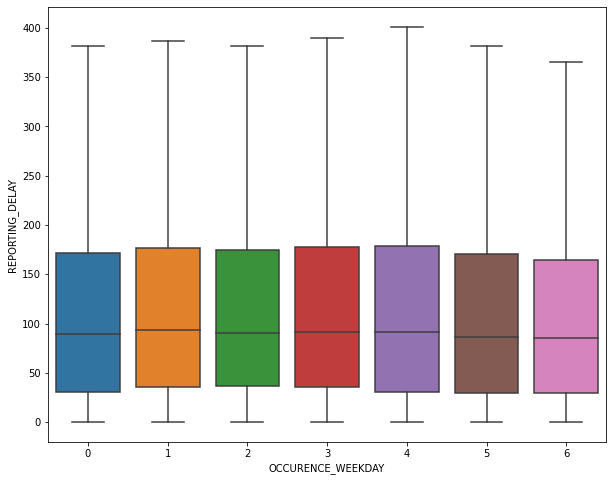

In [ ]:
plt.figure(figsize=(10, 8))
#sns.lineplot(x='OCCURENCE_WEEKDAY', y='REPORTING_DELAY', data=df_assault)
sns.boxplot(x='OCCURENCE_WEEKDAY', y='REPORTING_DELAY', data=df_assault, showfliers = False)

##Reporting Delay by Hour of Day

Here we start to find some more interesting and unexpected patterns. I would intuitively have expected the delay to be the greatest during the overnight night, but what actually emerges here is completely different:


1.   The greatest delay appears to be centered around the morning commute hours. With the increase beginning during the 5:00 hour and peaking during the 8:00 hour.
2.   The two other most significant jumps occur at midnight and at noon.



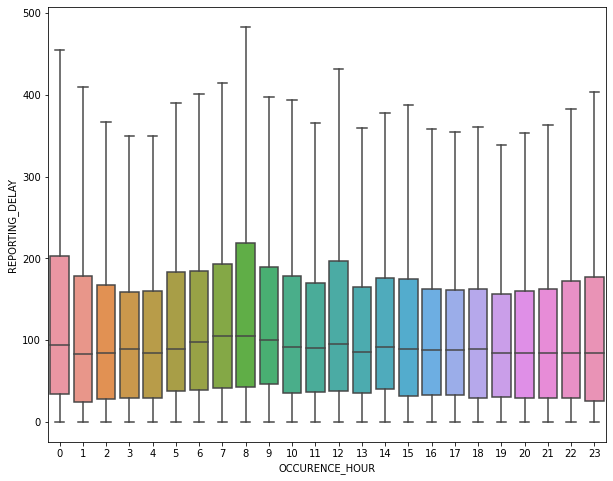

In [ ]:
plt.figure(figsize=(10, 8))
#sns.lineplot(x='OCCURENCE_HOUR', y='REPORTING_DELAY', data=df_assault)
sns.boxplot(x='OCCURENCE_HOUR', y='REPORTING_DELAY', data=df_assault, showfliers = False)

##Reporting Delay by Precinct

We can see here some pretty clear differences by precinct. Given the complexity and number of factors that could go into this, I chose to focus in the single precinct with the greatest mean, deviation, and range: Precinct 512


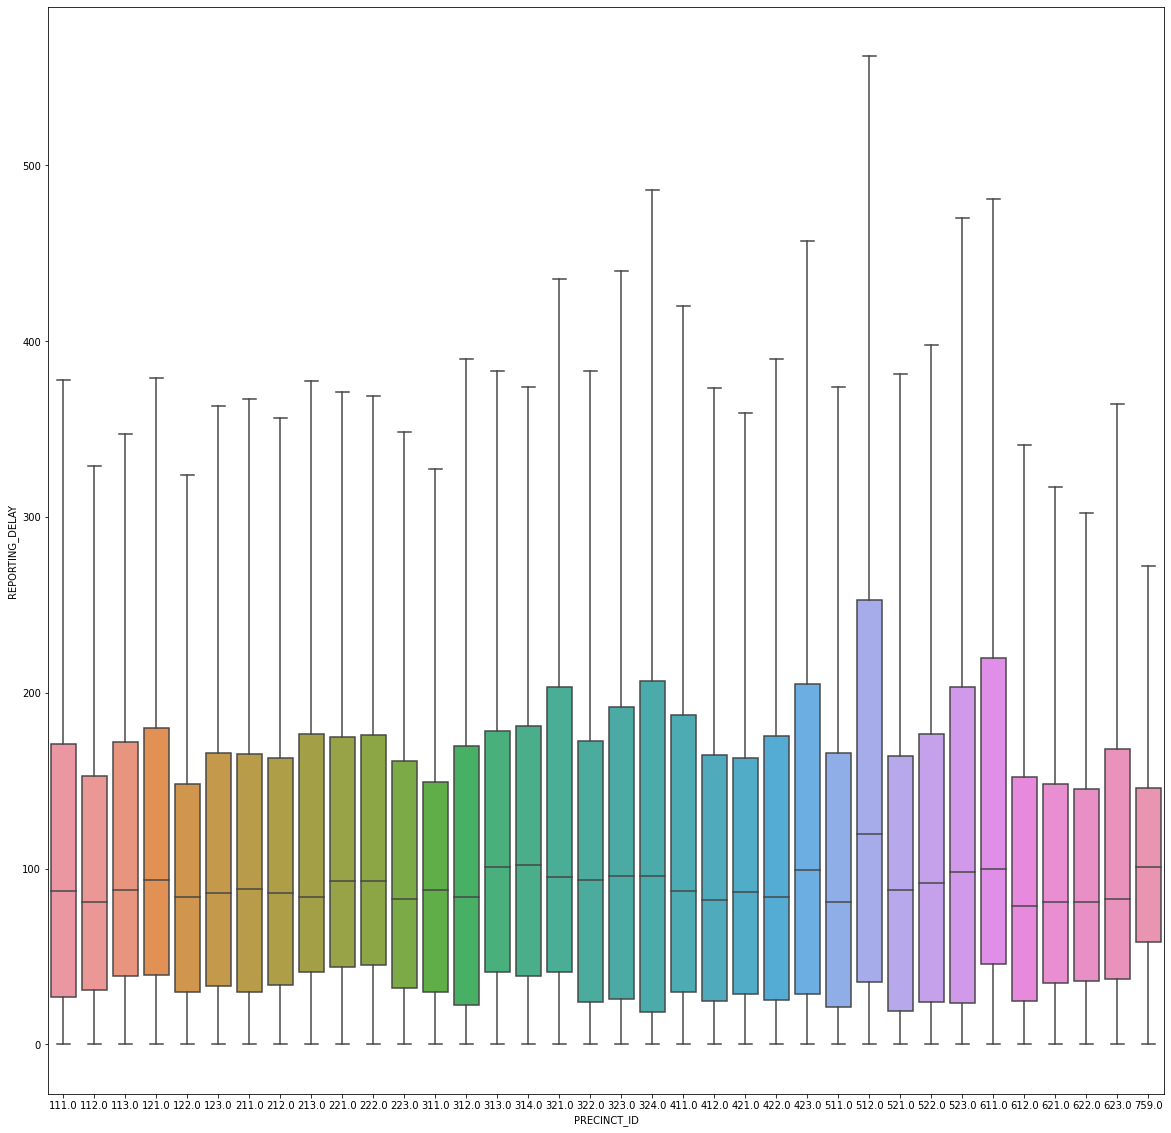

In [ ]:
plt.figure(figsize=(20, 20))
sns.boxplot(x='PRECINCT_ID', y='REPORTING_DELAY', data=df_assault, showfliers = False)

###Reporting Delay in Precinct 512 by Neighborhood

And here we're able to see that the reporting delays within the 512 are even more specifically related to crime within Central Park.

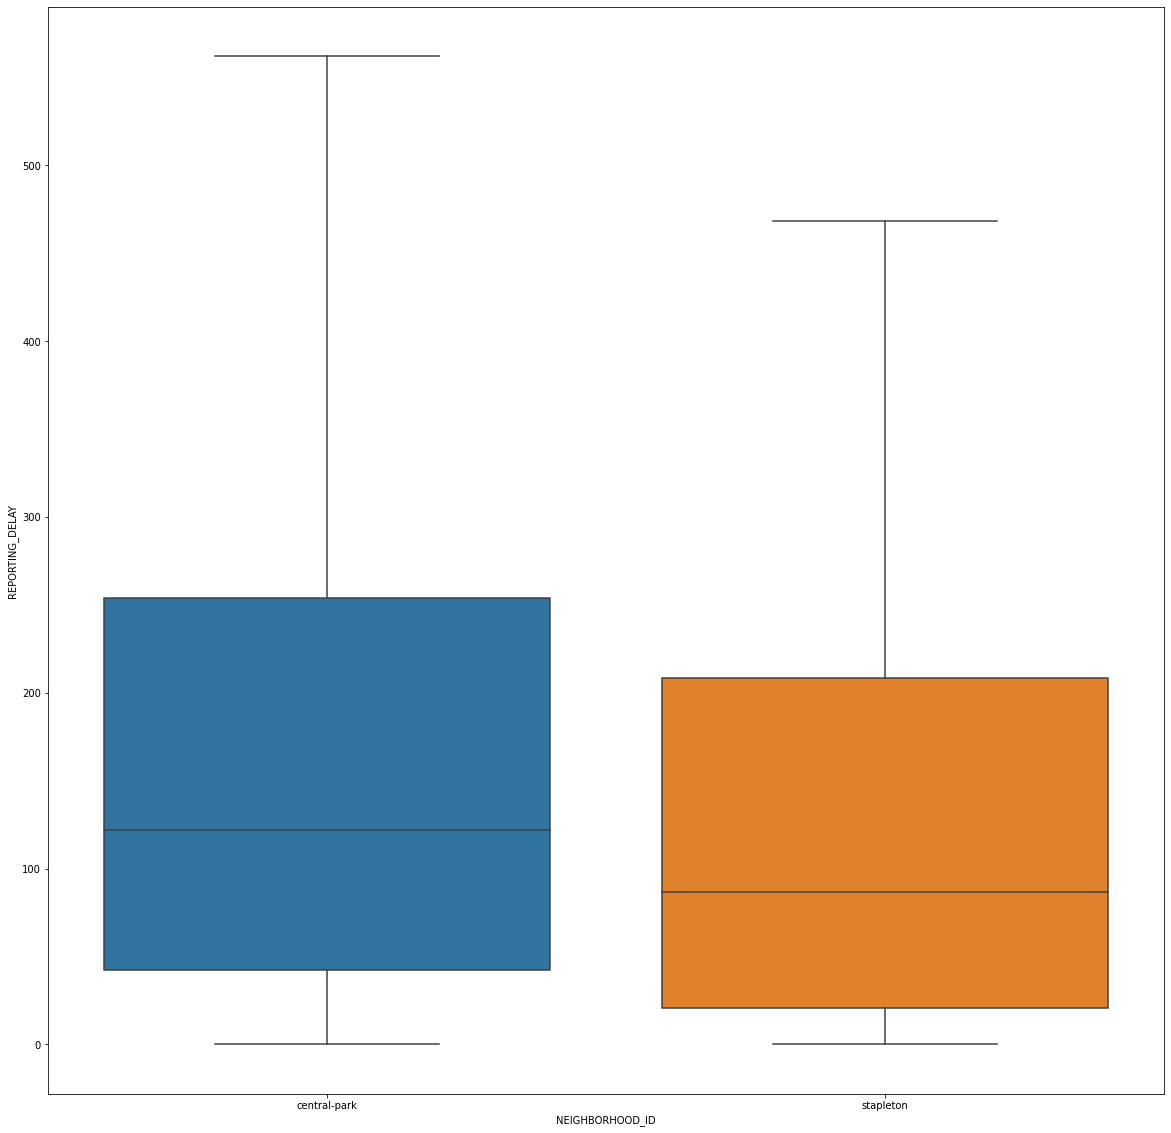

In [ ]:
plt.figure(figsize=(20, 20))
sns.boxplot(x='NEIGHBORHOOD_ID', y='REPORTING_DELAY', data=assault_512, showfliers = False)

# Recomendations

**Increase patrolling of Central Park.** 

> While in the longer term it may be more cost effective to increase electronic surveilance, add callboxes to rapidly connect to police or other hardware to the park, their funding and implementation will take some time whereas increased patrols can be implemented immediately and their effect rapidly measured.


**Begin logging total time spent dealing with minor traffic accidents.** 

> Specifically accidents where no party needs to be transported by ambulance and no car must be towed from the scene. The hours of the morning commute represent the single biggest, sustained spike in increased reporting times for violent crime. Increased traffic will represent at least some portion of this delay, however it needs to be considered additionally how much manpower is taken up during these hours dealing with the reporting and paperwork involved in minor traffic accidents. 

> If the time proves to be large enough during these hours, a change in how these sorts of accidents are handled needs to be considered. Increasingly, for example, insurance companies utilize apps where their customer simply photographs the damage to their car for making claims. An app could be developed that allows the people in the accident to both submit photos, scan their drivers licenses, and share insurance information without any officer having to be present.   
